In [63]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

import utils

# Load features and labels

In [56]:
data_path = '../data/'
# Load all users' work days
with open(data_path+'usr_work_days.pkl', 'rb') as f:
    USR_WORK_DAYS = pickle.load(f)


#label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/'
usr_id = '03996723-2411-4167-b14b-eb11dfc33124'
usr_path = data_path + usr_id + '/'

WIN_SIZE = 2 # second
OVERLAP = 0 # Zero overlapping between sliding windowss

features = list()
labels = list()

for day in USR_WORK_DAYS[usr_id]:
    print('Creating features on '+ day)
    data_fn = usr_path+'data'+day+'.npz'
    data = np.load(data_fn)
    ts = data['ts']
    offset = data['offset']
    accel = data['accel']
    gyro = data['gyro']
    step_cnt = data['step_cnt']
    act_type = data['act_type']
    lbl = data['labels']
    
    win_len = int(utils.INTERP_FREQ * WIN_SIZE) 
    overlap_len = int(utils.INTERP_FREQ * OVERLAP * WIN_SIZE)
    accel_x_wins = utils.generate_wins(accel[:, 0], win_len, overlap_len)
    accel_y_wins = utils.generate_wins(accel[:, 1], win_len, overlap_len)
    accel_z_wins = utils.generate_wins(accel[:, 2], win_len, overlap_len)
    
    gyro_x_wins = utils.generate_wins(gyro[:, 0], win_len, overlap_len)
    gyro_y_wins = utils.generate_wins(gyro[:, 1], win_len, overlap_len)
    gyro_z_wins = utils.generate_wins(gyro[:, 2], win_len, overlap_len)
    
    step_cnt_wins = utils.generate_wins(step_cnt[:, 0], win_len, overlap_len)
    act_type_wins = utils.generate_wins(act_type[:, 0], win_len, overlap_len)
    
    label_wins = utils.generate_wins(lbl, win_len, overlap_len)
    
    print(lbl.shape)

    features.append(np.hstack([accel_x_wins, accel_y_wins, accel_z_wins,
                               gyro_x_wins, gyro_y_wins, gyro_z_wins,
                               step_cnt_wins, act_type_wins]))
    
    labels.append(label_wins)
features = np.vstack(features)
labels = np.vstack(labels)
labels = stats.mode(labels, axis=1)[0][:, 0]

print('Feature matrix shape:', features.shape)
print('Label matrix shape:', labels.shape)

Creating features on 20171111
(21156,)
Creating features on 20171112
(858869,)
Creating features on 20171113
(791407,)
Creating features on 20171114
(575646,)
Creating features on 20171115
(793879,)
Creating features on 20171116
(804390,)
Creating features on 20171120
(796944,)
Creating features on 20171121
(771765,)
Creating features on 20171122
(768786,)
Creating features on 20171127
(734107,)
Creating features on 20171128
(851412,)
Creating features on 20171129
(771741,)
Creating features on 20171130
(540339,)
Creating features on 20171204
(802786,)
Creating features on 20171205
(734842,)
Creating features on 20171206
(834436,)
Creating features on 20171207
(850493,)
Creating features on 20171208
(833357,)
Creating features on 20171212
(833723,)
Creating features on 20171213
(774861,)
Creating features on 20171214
(819761,)
Creating features on 20171215
(826155,)
Creating features on 20171216
(731900,)
Creating features on 20171218
(790560,)
Creating features on 20171219
(811948,)
C

In [57]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 499358, 1.0: 144207}


# Balance classes and normailze feature matrix

In [50]:
zero_indices = np.where(labels==0)[0]
one_indices = np.where(labels==1)[0]

zero_indices = np.random.choice(zero_indices, size=one_indices.shape[0], replace=False)

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = labels[indices]
#new_features = normalize(features[indices])
new_features = features[indices]
print('Feature matrix shape:', new_features.shape)
print('Label matrix shape:', new_labels.shape)

Feature matrix shape: (288414, 320)
Label matrix shape: (288414,)


# Create train set, validation set, and test set

In [58]:
num_classes = 2
split_idx = int(new_features.shape[0] * 0.80)

X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx]

X_test = new_features[split_idx:]
Y_test = new_labels[split_idx:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
#Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('train data shape:', X_train.shape)
print('train label shape:', Y_train.shape)
#print('val data shape:', X_val.shape)
#print('val label shape:', Y_val.shape)
print('test data shape:', X_test.shape)
print('test label shape:', Y_test.shape)

train data shape: (230731, 320)
train label shape: (230731, 2)
test data shape: (57683, 320)
test label shape: (57683,)


# Create MLP classifier

In [59]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=256, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               82176     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 130       
Total para

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Train the model

In [60]:
epochs = 100
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)

callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks_list)
#validation_data=(X_val, Y_val),

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 184584 samples, validate on 46147 samples
Epoch 1/100
184584/184584 [==============================] - 3s 15us/step - loss: 0.6854 - acc: 0.6354 - val_loss: 0.6127 - val_acc: 0.6891

Epoch 00001: val_acc improved from -inf to 0.68906, saving model to ./DNN_Model-10Second
Epoch 2/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.6034 - acc: 0.6968 - val_loss: 0.5648 - val_acc: 0.7311

Epoch 00002: val_acc improved from 0.68906 to 0.73112, saving model to ./DNN_Model-10Second
Epoch 3/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5725 - acc: 0.7169 - val_loss: 0.5535 - val_acc: 0.7364

Epoch 00003: val_acc improved from 0.73112 to 0.73643, saving model to ./DNN_Model-10Second
Epoch 4/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5549 - acc: 0.7257 - val_loss: 0.5367 - val_acc: 0.7459

Epoch 00004: val_acc improved from 0.73643 to 0.74590, saving model to ./DNN_Model-10Second
Epoch 5/100
184584/1


Epoch 00039: val_acc did not improve from 0.80816
Epoch 40/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4378 - acc: 0.8023 - val_loss: 0.4568 - val_acc: 0.8039

Epoch 00040: val_acc did not improve from 0.80816
Epoch 41/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4378 - acc: 0.8009 - val_loss: 0.4735 - val_acc: 0.7839

Epoch 00041: val_acc did not improve from 0.80816
Epoch 42/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4353 - acc: 0.8040 - val_loss: 0.4480 - val_acc: 0.8023

Epoch 00042: val_acc did not improve from 0.80816
Epoch 43/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4331 - acc: 0.8059 - val_loss: 0.4453 - val_acc: 0.8045

Epoch 00043: val_acc did not improve from 0.80816
Epoch 44/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4309 - acc: 0.8062 - val_loss: 0.4425 - val_acc: 0.8148

Epoch 00044: val_acc improved from 0.80

184584/184584 [==============================] - 2s 12us/step - loss: 0.4114 - acc: 0.8153 - val_loss: 0.4352 - val_acc: 0.8172

Epoch 00082: val_acc did not improve from 0.82064
Epoch 83/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4105 - acc: 0.8164 - val_loss: 0.4489 - val_acc: 0.8097

Epoch 00083: val_acc did not improve from 0.82064
Epoch 84/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4099 - acc: 0.8161 - val_loss: 0.4438 - val_acc: 0.8150

Epoch 00084: val_acc did not improve from 0.82064
Epoch 85/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4136 - acc: 0.8135 - val_loss: 0.4363 - val_acc: 0.8180

Epoch 00085: val_acc did not improve from 0.82064
Epoch 86/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4083 - acc: 0.8174 - val_loss: 0.4415 - val_acc: 0.8120

Epoch 00086: val_acc did not improve from 0.82064
Epoch 87/100
184584/184584 [=========================

# Plot training accuracy vs testing accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


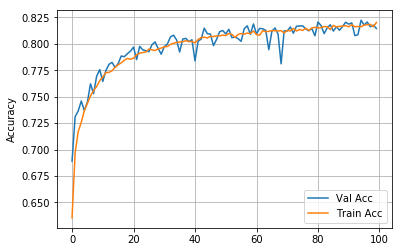

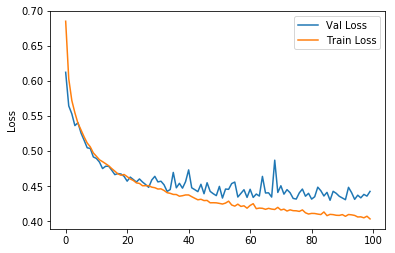

In [61]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()

# Print important metrics

Confusion Matrix:
 [[22054  6772]
 [ 3933 24924]]
Accuracy: 0.8144167258984449
F1 score: 0.8232127227387578


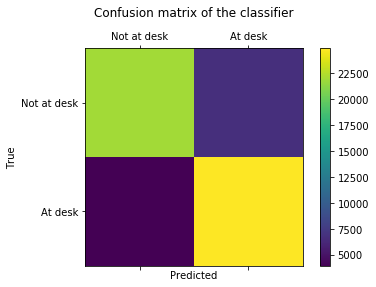

In [75]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_true = Y_test
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print('Confusion Matrix:\n', cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print('F1 score:', f1_score(y_true, y_pred))

class_labels = ['Not at desk', 'At desk']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()